# Modeling Growth of a Recently Nucleated Bubble

In video `v360_co2_8987_017_050_0200_94_295_04_7.mp4` from experiments on VORANOL 360-CO2 foaming performed on August 29, 2020, bubbles were observed to nucleate in frames 7303, 12346, and 13099, and subsequently grow. While the nucleation occurred near the exit of the observation capillary, the pressure is only expected to have dropped from 6 to 5 bar along the field of view. I believe that this pressure drop is insufficient to explain the rapid growth of these bubbles, so I want to model their growth with the Epstein-Plesset model to see if diffusion is sufficient to explain the growth. If diffusion cannot explain the fast growth, I will conclude that the pressure dropped more quickly than estimated based on Poiseuille flow.

In [1]:
# adds custom libraries to path
import sys
sys.path.append('src/')
sys.path.append('../libs/')

# import libraries
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize
import scipy.interpolate

# custom libraries
import bubble
import plot.bubble as pltb
import analytics as an
import flow

from importlib import reload
reload(bubble)
reload(an)

# lists data files required
# load data (interfacial tension, solubility, and diffusivity) for polyols? we don't have data for VORANOL 360...use 1k3f
polyol_data_file = 'input/1k3f_22c.csv'
# load CO2 equation of state data for desired temperature [csv]
eos_co2_file = 'input/eos_co2_22-0C.csv'
# folder to save figures
save_folder = 'figs/'
save_figs = True

### PARAMETRES OF THE EXPERIMENT ###
# viscosity of inner and outer streams [Pa.s]
eta_i = 0.25 # rough estimate of VORANOL 360 + CO2 dissolved so should be lower
eta_o = 4.815
# length of observation capillary [m]
L = 10E-2
# outer stream radius [m]
R_o = 150E-6
R_nuc = 4E-9  # initial bubble radius, estimated as a bit larger than prediction in slide 13 of 20200305_aps_march_meeting [m]
p_atm = 101.3E3 # atmospheric pressure, assumed to be outlet pressure [Pa]
Q_o = 200/60E9 # outer stream flow rate, input to ISCO 260 D [m^3/s]
Q_i = 50/60E9 # inner stream flow rate, input to ISCO 100 DM [m^3/s]
p_s = 80E5 # saturation pressure of CO2 in VORANOL 360 [Pa]
# distance along channel where bubble was observed [m]
d = 0.094
# frame rate [fps]
fps = 8987 

### PARAMETERS OF THE MODEL
dt = 1E-10 # sets the time step for numerical model [s]
growth_fn = bubble.grow
adaptive_dt = True
if_tension_model = 'ceil'
implicit = False
d_tolman = 5E-9
tol_R = 1E-3
alpha = 0.5
# tolerance on radius of bubble measurement [fractional], estimated by uncertainty in bubble measurement
sigma_R = 0.01

# CONVERSIONS
s_2_ms = 1000
s_2_us = 1E6
kg_2_g = 1E3
kg_2_ng = 1E12
kgm3_2_gmL = 1E-3
m_2_mm = 1000
m_2_um = 1E6
m_2_nm = 1E9
Pa_2_bar = 1E-5
Pa_2_MPa = 1E-6
Nm_2_mNm = 1000

## Compute Properties of Sheath Flow

In [2]:
# computes properties of flow in observation capillary
dp, R_i, v = flow.get_dp_R_i_v_max(eta_i, eta_o, L, Q_i, Q_o, R_o, SI=True)
p_in = p_atm - dp # subtracts dp because it is negative (dp = p_atm - p_in)

## Load Bubble Sizes and Metadata

We will look at the bubble in frames 12898-12921.

In [3]:
# initial and final frames with bubbles
f_i = 12898
f_f = 12921
R_bubble = 4E-6 # bubble radius in first frame [m]
x_bubble = d # distance traveled along channel [m]
t_bubble = x_bubble / v # time bubble had traveled down channel [s]

# additional bubbles
f_bubbles = [i for i in range(f_i+1, f_f+1)]
R_bubbles = np.array([7.8, 9, 9.2, 11, 12, 13.5, 15, 16, 17.7, 19, 20, 20, 21, 21.4, 22.4, 24, 25, 26, 27, 29.5, 28.5, 30.5, 
             32.3])/m_2_um
t_bubbles = [t_bubble + (f - f_i)/fps for f in f_bubbles]

### 1) Model Bubble Growth with Epstein-Plesset Model

Our first model will use the Epstein-Plesset model and a fixed diffusivity, selected to match the bubble size data.

#### Predict Nucleation Time

t_nuc = 385.040 ms and error in R is 0.0364.
t_nuc = 385.015 ms and error in R is 0.1928.
t_nuc = 385.028 ms and error in R is 0.0841.
t_nuc = 385.034 ms and error in R is 0.0254.
t_nuc = 385.037 ms and error in R is 0.0050.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 385.037 ms


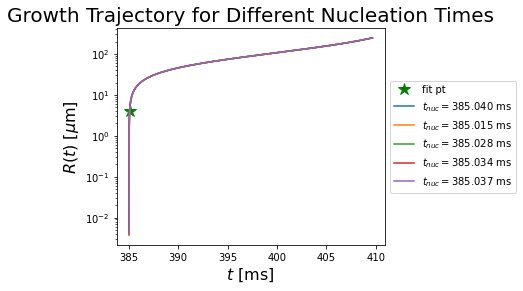

In [4]:
### THIS IS THE FLAG THAT DROPS THE PESKY 1/SQRT(PI*D*T) TERM FOR EASIER COMPUTATIONS NEAR NUCLEATION TIME ###
drop_t_term = False # drops 1/sqrt(pi*D*t) term that accounts for effect of sharp interface at the beginning
# sets diffusivity to fixed value [m^2/s]
D1 = 0.25E-9 

# bounds on nucleation time
t_nuc_lo = t_bubble - 0.0001 # [s]
t_nuc_hi = t_bubble # [s]

# opens figure to show results of different guesses for bubble nucleation time
fig = plt.figure()
ax = fig.add_subplot(111)

# computes bubble growth trajectory using modified Epstein-Plesset model
args = [dt, p_s, R_nuc, p_atm, L, p_in, v, polyol_data_file, eos_co2_file, adaptive_dt, if_tension_model, 
        implicit, d_tolman, tol_R, alpha, D1, drop_t_term]
i_t_nuc = 1

# uses modified shooting method to estimate the nucleation time
t_nuc1, results = an.fit_growth_to_pt(t_bubble, R_bubble, t_nuc_lo, t_nuc_hi, growth_fn, args,
                     i_t_nuc, sigma_R=sigma_R, ax=ax)

t1, m, D1, p, p_bubble, if_tension, c_s, R, rho_co2 = results
props_list1 = (R, m, p, p_bubble, rho_co2, if_tension)

#### Plot Results

Model prediction at fit point is R = 3.978264 um.


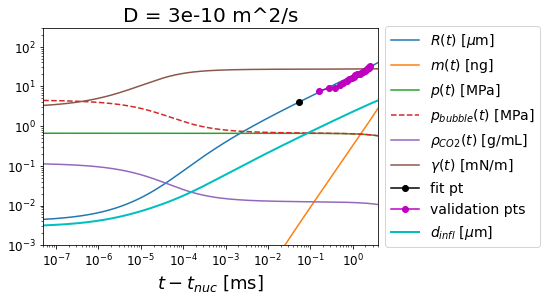

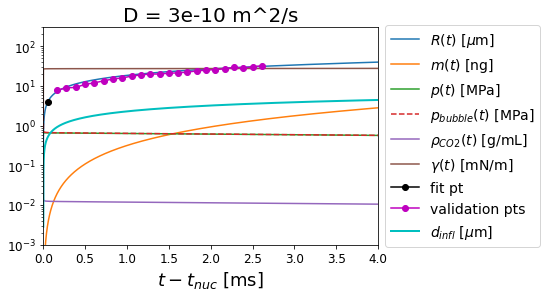

In [16]:
reload(pltb)
# log time axis
x_lim = [0.00000005, 4]
y_lim = [0.001, 300]
x_log = True
title = 'D = {0:.1g} m^2/s'.format(D1)
ax = pltb.all_props(t1, t_nuc1, props_list1, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
ax = pltb.measured(ax, t_nuc1, t_bubble, t_bubbles, R_bubble, R_bubbles, t_R=(t1, props_list1[0]))
ax = pltb.d_infl(ax, t1, t_nuc1, props_list1, c_s[0])
pltb.legend(ax)

# linear time axis
x_lim = [0.0, 4]
y_lim = [0.001, 300]
x_log = False
ax = pltb.all_props(t1, t_nuc1, props_list1, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
ax = pltb.measured(ax, t_nuc1, t_bubble, t_bubbles, R_bubble, R_bubbles)
ax = pltb.d_infl(ax, t1, t_nuc1, props_list1, c_s[0])

pltb.legend(ax)

### Drop the "t" Term and Raise the Diffusivity

Our second model will exclude the $\frac{1}{\sqrt{\pi D t}}$ term in the Epstein-Plesset equation to avoid numerical difficulties. To match the data, this model will require a much higher diffusivity.

t_nuc = 385.040 ms and error in R is 0.0234.
t_nuc = 385.015 ms and error in R is 0.1995.
t_nuc = 385.028 ms and error in R is 0.0934.
t_nuc = 385.034 ms and error in R is 0.0365.
t_nuc = 385.037 ms and error in R is 0.0069.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 385.037 ms


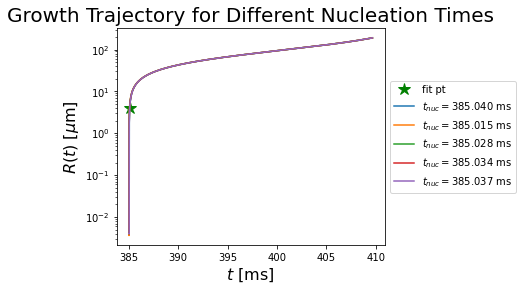

In [17]:
### THIS IS THE FLAG THAT DROPS THE PESKY 1/SQRT(PI*D*T) TERM FOR EASIER COMPUTATIONS NEAR NUCLEATION TIME ###
drop_t_term = True # drops 1/sqrt(pi*D*t) term that accounts for effect of sharp interface at the beginning
# sets diffusivity to fixed value [m^2/s]
D2 = 5E-9 

# bounds on nucleation time
t_nuc_lo = t_bubble - 0.0001 # [s]
t_nuc_hi = t_bubble # [s]

# opens figure to show results of different guesses for bubble nucleation time
fig = plt.figure()
ax = fig.add_subplot(111)

# computes bubble growth trajectory using modified Epstein-Plesset model
args = [dt, p_s, R_nuc, p_atm, L, p_in, v, polyol_data_file, eos_co2_file, adaptive_dt, if_tension_model, 
        implicit, d_tolman, tol_R, alpha, D2, drop_t_term]
i_t_nuc = 1

# uses modified shooting method to estimate the nucleation time
t_nuc2, results = an.fit_growth_to_pt(t_bubble, R_bubble, t_nuc_lo, t_nuc_hi, growth_fn, args,
                     i_t_nuc, sigma_R=sigma_R, ax=ax)

t2, m, D2, p, p_bubble, if_tension, c_s, R, rho_co2 = results
props_list2 = (R, m, p, p_bubble, rho_co2, if_tension)

#### Plot Results

Model prediction at fit point is R = 4.026276 um.


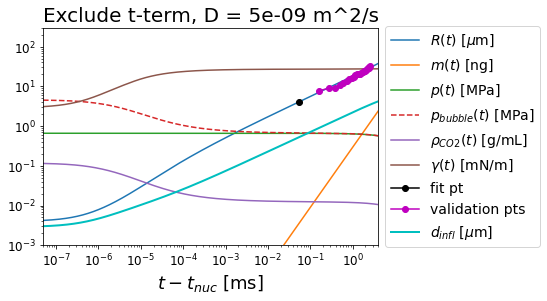

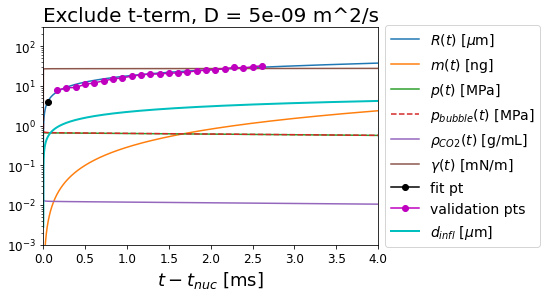

In [18]:
# log time axis
x_lim = [0.00000005, 4]
y_lim = [0.001, 300]
x_log = True
title = 'Exclude t-term, D = {0:.1g} m^2/s'.format(D2)
ax = pltb.all_props(t2, t_nuc2, props_list2, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
ax = pltb.measured(ax, t_nuc2, t_bubble, t_bubbles, R_bubble, R_bubbles, t_R=(t2, props_list2[0]))
ax = pltb.d_infl(ax, t2, t_nuc2, props_list2, c_s[0])
pltb.legend(ax)

# linear time axis
x_lim = [0.0, 4]
y_lim = [0.001, 300]
x_log = False
ax = pltb.all_props(t2, t_nuc2, props_list2, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
ax = pltb.measured(ax, t_nuc2, t_bubble, t_bubbles, R_bubble, R_bubbles)
ax = pltb.d_infl(ax, t2, t_nuc2, props_list2, c_s[0])

pltb.legend(ax)

## Examine Ratio Between Results

The results look almost identical, but they use different diffusivities ($2.5 \times 10^{-10}~m^2/s$ and $5.0 \times 10^{-9}~m^2/s$). My derivation in `Epstein-Plesset Derivations` on Overleaf found that the ratio between the results with and without the $t$-dependent term is $\sqrt{\frac{c_{bulk} - c_{sat}}{2\pi \rho_{CO2}}}$ when this ratio is large. The radius was found to scale with the diffusivity $\sqrt{D}$.

In [19]:
reload(bubble)
### THIS IS THE FLAG THAT DROPS THE PESKY 1/SQRT(PI*D*T) TERM FOR EASIER COMPUTATIONS NEAR NUCLEATION TIME ###
drop_t_term = False # drops 1/sqrt(pi*D*t) term that accounts for effect of sharp interface at the beginning
# sets diffusivity to fixed value [m^2/s]
D = D1 
t_nuc1 = 0.38503700023932297 # previously computed value [s]
# computes bubble growth trajectory using modified Epstein-Plesset model
t, m, D, p, p_bubble, if_tension, c_s, c_bulk, R, rho_co2 = bubble.grow(dt, t_nuc1, p_s, R_nuc, p_atm, L, p_in, v,
                                                                polyol_data_file, eos_co2_file, adaptive_dt=True, 
                                                                implicit=False, drop_t_term=drop_t_term, D=D)

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubble.py:431: RuntimeWarning: divide by zero encountered in double_scalars
  res1  = R - ( 3/(4*np.pi)*(m/f_rho_co2(p_bubble)) )**(1/3.)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\scipy\interpolate\interpolate.py:683: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\scipy\interpolate\interpolate.py:684: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Text(0.5, 1.0, '$p_{sat}$ = 80.0 bar, nucleation at  94 mm, 6.6 bar')

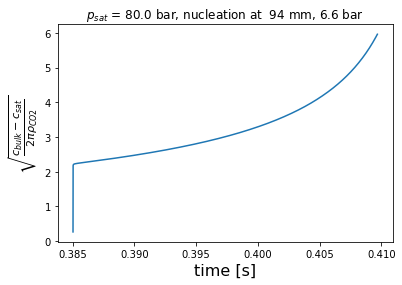

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, np.sqrt((c_bulk - np.array(c_s)) / ((2*np.pi)*np.array(rho_co2))))
ax.set_xlabel('time [s]', fontsize=16)
ax.set_ylabel(r'$\sqrt{\frac{c_{bulk}-c_{sat}}{2\pi \rho_{CO2}}}$', fontsize=16)
ax.set_title(r'$p_{sat}$' + ' = {0:.1f} bar, nucleation at  {1:d} mm, {2:.1f} bar'.format(p_s/1E5, int(d*1000), p[0]/1E5))

In [24]:
c_s[0]

28.33782817856389

In [25]:
m[-1]

1.1539139409004146e-10